In [1]:
import numpy as np
from numpy import sqrt
from numpy import pi
from scipy.integrate import trapz
import emcee
import corner
import matplotlib.pyplot as plt
from lmfit import Model
import lmfit
from lmfit import Parameters
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import signal
import statistics

In [2]:
speed_of_light=2.99792e5
#rest_wl_si_1=6347.103      umut original
#rest_wl_si_2=6371.359      umut original    

rest_wl_si_1=5957.56
rest_wl_si_2=5978.93

def vel_to_wl(vel,rest_wl_line):
    zmeas=-1.0+np.sqrt( (1.0+(vel/speed_of_light))/(1.0-(vel/speed_of_light)) )
    wl=(zmeas*rest_wl_line)+rest_wl_line
    return wl

def wl_to_vel(wavelength, redshift):
    vel = speed_of_light * (redshift + 1) * ((wavelength / rest_wl_si_1) - 1)
    return vel

def g_sil1(x,a_sil1,v_sil1,fwhm_sil1):
    zmeas=(x-rest_wl_si_1)/rest_wl_si_1
    vel=(( (zmeas+1.0)**2 - 1.0 )*speed_of_light/(1.+(1.+zmeas)**2))/1e4
    sigma_gaussian=np.abs(fwhm_sil1)/2.35482
    gaussian=a_sil1*np.exp(-np.power(vel - v_sil1, 2.) / (2 * np.power(sigma_gaussian, 2.)))
    return gaussian
def g_sil2(x,a_sil2,v_sil2,fwhm_sil2):
    zmeas=(x-rest_wl_si_2)/rest_wl_si_2
    vel=(( (zmeas+1.0)**2 - 1.0 )*speed_of_light/(1.+(1.+zmeas)**2))/1e4
    sigma_gaussian=np.abs(fwhm_sil2)/2.35482
    gaussian=a_sil2*np.exp(-np.power(vel - v_sil2, 2.) / (2 * np.power(sigma_gaussian, 2.)))
    return gaussian
def line(x, slope,intercept):
    return slope*x + intercept
def const(x):
    return 1.0

In [3]:
#df = pd.read_csv("/Users/umutburgaz/ZTFWork/25_Jun/bunlari_calculate_snr.csv")     umut original
df = pd.read_csv(r'C:\Users\senan\OneDrive\Desktop\Capstone\dereddened_files_est_5972.csv')

spec_array=df['filename']
spec_name=df['ztfname']
redshift=df['redshift']

sil_vel=[]
sil_vel_err=[]
sil_fwhm=[]
sil_fwhm_err=[]

i=[-0.4,-1.0,1.0]

width_cont=26.0

snr_list = []

ahh = 'hello\goodbye'  # just to get the slash in a string
slash = ahh[5] 
path_stem = r'C:\Users\senan\OneDrive\Desktop\Capstone\dereddend_spectra_and_Si_figures'

for index, row in df.iterrows():
    # spec_file='/Users/umutburgaz/ZTFWork/a_May_28_new/mw_all/'+row['filename']                 umut original
    # data = np.loadtxt(spec_file,dtype={'names': ('wl', 'fl'),'formats': ('f8', 'f8')} )        umut original
    
    # wl_fit1=data['wl']/(1+row['redshift'])        umut original
    # fl_fit1=data['fl']                            umut original
    # flerr_fit1=data['fl']*0.01                    umut original

    spec_file = path_stem + slash + row['filename']
    data = pd.read_csv(spec_file)

    wl_fit1=np.array(data['wl'])/(1+row['redshift'])
    fl_fit1=np.array(data['fl'])
    flerr_fit1=np.array(data['fl'])*0.01

    #v_x1=row['v_x1_6355']      umut origianl 
    v_x1=row['v_x1_5972']
    zmeas=-1.0+np.sqrt( (1.0+(v_x1/speed_of_light))/(1.0-(v_x1/speed_of_light)) )
    wl_x1=(zmeas*rest_wl_si_1)+rest_wl_si_1

    #v_x2=row['v_x2_6355']      umut original
    v_x2=row['v_x2_5972']
    zmeas=-1.0+np.sqrt( (1.0+(v_x2/speed_of_light))/(1.0-(v_x2/speed_of_light)) )
    wl_x2=(zmeas*rest_wl_si_1)+rest_wl_si_1

    x1=wl_x1
    x2=wl_x2

    wcont=np.where( np.logical_or(np.logical_and(wl_fit1 > x1-width_cont,wl_fit1 < x1+width_cont) , np.logical_and(wl_fit1 > x2-width_cont,wl_fit1 < x2+width_cont))  )

    xcont=wl_fit1[wcont]
    ycont=fl_fit1[wcont]
    yerrcont=flerr_fit1[wcont]
    cont_res = np.polyfit(xcont,ycont,1,w=1.0/yerrcont)

    w=np.where( np.logical_and(wl_fit1 > x1,wl_fit1 < x2))
    x=wl_fit1[w]

    cont_fit=cont_res[1]+x*cont_res[0]
    cont2=cont_res[1]+wl_fit1*cont_res[0]
    y=(fl_fit1[w]/cont_fit)-1
    yerr=flerr_fit1[w]/cont_fit

    model = Model(g_sil1)+Model(g_sil2)

    pars = Parameters()
    pars.add('a_sil1', value=i[0], max=0.0)
    pars.add('v_sil1', value=i[1], min=-4.0, max=0.0)
    pars.add('fwhm_sil1', value=i[2], min=0.0)
    pars.add('a_sil2', expr='a_sil1')
    pars.add('v_sil2', expr='v_sil1')
    pars.add('fwhm_sil2', expr='fwhm_sil1')
    
#     print(spec_file)
    out = model.fit(y, pars, x=x, weights=1.0/yerr)

    # Get the best-fit values from the output
    best_fit_params = [out.params['a_sil1'].value, out.params['v_sil1'].value, out.params['fwhm_sil1'].value]

    # Calculate the model values using the best-fit parameters
    model_values = model.eval(params=out.params, x=x)

    # Calculate the residuals (observed - model)
    residuals = y - model_values

    # Calculate the squared residuals
    squared_residuals = residuals**2

    # Calculate the mean squared residual
    mean_squared_residual = np.mean(squared_residuals)

    # Calculate the RMS
    rms = np.sqrt(mean_squared_residual)

    peak_signal = np.max(model_values)
    background_signal = np.min(model_values)

    # Calculate the difference between peak signal and background signal
    signal_difference = peak_signal - background_signal

    # Calculate SNR using the RMS value
    snr = signal_difference / rms
    snr_list.append(snr)

final_df = pd.DataFrame(
    {'ztfname': df['ztfname'],
     'filename': df['filename'],
     'SNR_new': snr_list,
    })

#%%

#creates file
#output_csv = final_df
#output_csv

#final_df.to_csv("/Users/umutburgaz/ZTFWork/25_Jun/new_ones_SNR_calculated_36.csv", index=False) 

Text(0, 0.5, 'frequency')

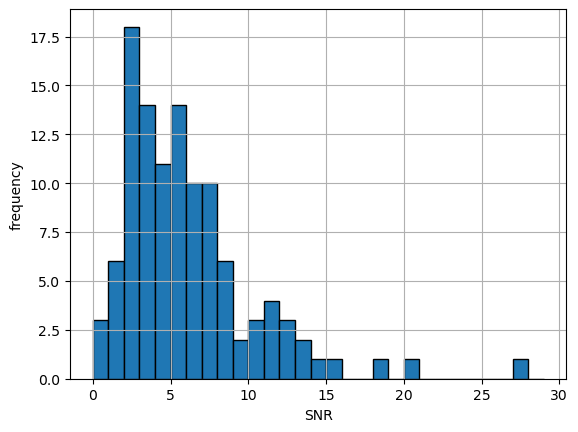

In [4]:
final_df['SNR_new'].hist(edgecolor='k', bins=range(0,30,1))
plt.xlabel('SNR')
plt.ylabel('frequency')

In [5]:
name = np.array(final_df['ztfname'])
file = np.array(final_df['filename'])
snr = np.array(final_df['SNR_new'])

name_list = []
file_list = []
snr_list = []

for i in range(len(name)):
    if snr[i] >=4:
        name_list.append(name[i])
        file_list.append(file[i])
        snr_list.append(snr[i])
print(len(name_list))

70


In [6]:
info = pd.read_csv(r'C:\Users\senan\OneDrive\Desktop\Capstone\Final_table_allinfo_allcuts.csv')

info.insert(11,'SNR', snr, True)

v1 = np.array(df['v_x1_5972'])
v2 = np.array(df['v_x2_5972'])

info.insert(11, 'v_x1_5972', v1, True)
info.insert(11, 'v_x2_5972', v2, True)
#info.to_csv('Master_info.csv')
info

,Unnamed: 0,ztfname,File Name,Dereddened File Name,Date of spectrum,MJD of spectrum,t0,Phase of spectrum,t0_err,z,z_err,v_x2_5972,v_x1_5972,SNR,x1,x1_err,MWEBV,MWEBV_err,SN Type,SN Sub Type
0,0,ZTF18aabstmw,ZTF18aabstmw_20180307_LCO-FLOYDS_0.ascii,ZTF18aabstmw_20180307_LCO-FLOYDS_0_dereddened.csv,20180307,58184.0,58190.750251,-6.750251,0.103113,0.023086,0.0,-3850.806452,-19092.741935,13.541965,-1.527619,0.110240,0.011197,0.0,snia-pec,91bg
1,1,ZTF18aabstmw,ZTF18aabstmw_20180307_SEDm_0.ascii,ZTF18aabstmw_20180307_SEDm_0_dereddened.csv,20180307,58184.0,58190.750251,-6.750251,0.103113,0.023086,0.0,-4415.322581,-16411.290323,11.290045,-1.527619,0.110240,0.011197,0.0,snia-pec,91bg
2,2,ZTF18aasprui,ZTF18aasprui_20180804_P200_0.ascii,ZTF18aasprui_20180804_P200_0_dereddened.csv,20180804,58334.0,58347.543842,-13.543842,0.093703,0.038051,0.0,-3850.806452,-14576.612903,3.992119,-2.013348,0.048069,0.014113,0.0,snia-cosmo,norm/04gs
3,3,ZTF18aauizcr,ZTF18aauizcr_20180519_APO_0.ascii,ZTF18aauizcr_20180519_APO_0_dereddened.csv,20180519,58257.0,58266.113751,-9.113751,0.096129,0.033914,0.0,-6673.387097,-19375.000000,3.463640,-1.824639,0.110901,0.015826,0.0,snia-cosmo,norm
4,4,ZTF18aauizcr,ZTF18aauizcr_20180519_SEDm_0.ascii,ZTF18aauizcr_20180519_SEDm_0_dereddened.csv,20180519,58257.0,58266.113751,-9.113751,0.096129,0.033914,0.0,-8649.193548,-19516.129032,12.078255,-1.824639,0.110901,0.015826,0.0,snia-cosmo,norm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,106,ZTF20acvziuf,ZTF20acvziuf_20201210_SEDm_0.ascii,ZTF20acvziuf_20201210_SEDm_0_dereddened.csv,20201210,59193.0,59205.088887,-12.088887,0.083822,0.017212,0.0,-8225.806452,-18810.483871,8.529830,-2.522307,0.070503,0.039908,0.0,snia-cosmo,norm
107,107,ZTF20acyhena,ZTF20acyhena_20201114_SNIFS_0.ascii,ZTF20acyhena_20201114_SNIFS_0_dereddened.csv,20201114,59167.0,59172.717945,-5.717945,5.591010,0.034170,0.0,-4697.580645,-16975.806452,2.728264,-2.107554,2.835029,0.024420,0.0,snia-cosmo,norm
108,108,ZTF20acynjjo,ZTF20acynjjo_20201222_CMO-2.5m_0.ascii,ZTF20acynjjo_20201222_CMO-2.5m_0_dereddened.csv,20201222,59205.0,59216.656929,-11.656929,0.433611,0.015873,0.0,-5967.741935,-20362.903226,1.427533,-2.156344,0.796144,0.113833,0.0,snia-cosmo,norm
109,109,ZTF20acynjjo,ZTF20acynjjo_20201222_SEDm_0.ascii,ZTF20acynjjo_20201222_SEDm_0_dereddened.csv,20201222,59205.0,59216.656929,-11.656929,0.433611,0.015873,0.0,-8649.193548,-19516.129032,7.950872,-2.156344,0.796144,0.113833,0.0,snia-cosmo,norm
